# Forecast River Flow

From literature review, two forcasting methods successfully applied in time series analysis are identified, namely the [Auto-Regressive Integrated Moving Average](https://faculty.fuqua.duke.edu/~rnau/Decision411_2007/411arim.htm) (ARIMA) from classical statistical methods and [Long-Short Term Memory](https://medium.com/explore-artificial-intelligence/an-introduction-to-recurrent-neural-networks-72c97bf0912) (LSTM) from deep learning approaches.  In this project, these two methods are implemented to forecast river discharge (flow) in the Yakima Gap-to-Gap reach of the Yakima River, Washington. 

The tasks applied are:
1. Select performance measures
2. Fit and optimize ARIMA model
3. Train and optimize LSTM model

This specific notebook presents methods used to fit and optimize ARIMA forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from datetime import datetime
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from pylab import rcParams
from pandas import Series
import warnings

# Data for 1Q10 analysis
yakima_450_discharge = pd.read_csv('yakima_450_discharge.csv') # saved copy from cleaned and transformed data
yakima_540 = yakima_450_discharge.copy()
yakima_540 = yakima_450_discharge.set_index('date')
yakima_540.index = pd.to_datetime(yakima_540.index)

# Data for 10Q10 analysis (seven days average)
yakima_7_avg = yakima_540.rolling(7).mean().dropna()

## Performance Measures

+ MASE (mean absolute scaled error)- compare the mean absolute error of the model to the naive forecast
+ MAPE (mean absolue percent error) - the percentage of the forecast error compared to the observed value
+ RMSE (root mean squared error) - the squared difference between the observed and forecasted values, finds the average, and then finds the square root

In [2]:
performance = pd.DataFrame({'Model' : [],
                            'Data Period':[],
                           'Mean Absolute Scaled Error (MASE)': [],
                          'Root Mean squared Error (RMSE)': [],
                          'Mean Absolue Percent Error (MAPE)': []})

In [3]:
def root_mean_squared_error(y_observed, y_forcasted):
    rmse = int(np.sqrt(mean_squared_error(y_forcasted, y_observed)))
    return rmse

In [4]:
def mean_absolute_percentage_error(y_observed, y_forcasted): 
    y_observed, y_forcasted = np.array(y_observed), np.array(y_forcasted)
    mape = int(np.mean(np.abs((y_observed - y_forcasted) / y_observed)) * 100)
    return mape

In [5]:
def mean__absolute_scaled_error(rmse, y_naive):
    mase = int(np.sqrt(rmse)/y_naive)*100
    return mase

## Naive (Baseline) Forecast
The baseline forecast is used to understand how well the observed data at a prior time step (t-1) predict the observation at the current time step (t). A baseline forecast performance also gives an idea of how well all other models will actually perform on on this problem. This provides a lower acceptable bound of model performance.

In [6]:
## naive forcast based on 7 days (arbitrary cutoff)
def naive_forcast(df):
    df = df.values 
    # data at time t
    train_data = df[:int(len(df)*0.5)]
    test_data = df[int(len(df)*0.5):len((df))]


    history = [x for x in train_data]
    predictions = list()
    for i in range(len(test_data)):
        # make prediction
        predictions.append(history[-7])
        # observation
        history.append(test_data[i])
       # report performance
    return test_data, predictions

In [7]:
naive_observed, naive_forcasted = naive_forcast(yakima_540)
rmse_naive = root_mean_squared_error(naive_observed, naive_forcasted)
mape_naive = mean_absolute_percentage_error(naive_observed, naive_forcasted)

In [71]:
row = performance.shape[0]
performance.loc[row] = ['Naive Forcast', '12 months', '-', rmse_naive, mape_naive]

In [72]:
performance

,Model,Data Period,Mean Absolute Scaled Error (MASE),Root Mean squared Error (RMSE),Mean Absolue Percent Error (MAPE)
0,Naive Forcast,12 months,-,2067.0,21.0


## Fit ARIMA Model

ARIMA model is represented by lags of the differenced series appearing in the forecasting equation are called "auto-regressive" terms (p), lags of the forecast errors are called "moving average" terms (d), and a time series which needs to be differenced to be made stationary is said to be an "integrated" version of a stationary series (q). The Seasonal ARIMA SARIMA) is estimated with (p,q,d)(P, D, Q)S parameters.
+ (p,q, d)- non-seasonal component
+ (P, D, Q) - seasonal component
+ s - periodicity of the time series

+ P, p - lag of dependent variable. For example, if p is 3, the predictors for x(t) will depend on x(t-1)…x(t-3)
+ D, d - lagged forecast errors. For example,  if q is 3, the predictors for x(t) will be e(t-1)…e(t-4) where e(i) is the difference between the moving average at ith instant and actual value.
+ Q, q - number of nonseasonal differences. For example,  if we use first order difference variable, then d = 0 or if we use the original observed variable, d = 1.

Mathematically represented as:

Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

$$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \beta_3 Y_{t-3} + ...+ \beta_p Y_{t-p} \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + ...+ \phi_q \epsilon_{t-q}$$

Steps to fit ARIMA
1. Examining data stationarity
   + Many time series modeling approaches are based on the assumption that the data are stationary. Time series stationarity needs to be tested. Non-stationary time series need to be transformed into stationary.
2. Select Optimum model parameters
3. Fit ARIMA
4. Validate and optimize

### Select Optimum Parameters

A different combinations of parameters are iteratively explored. For each combination of parameters a new model is fit and optimum parameters were selected that corresponds to the best performing model. 

## Examine Stationarity of Discharge Time Series

A time series data is said to be stationary if statistical properties such as mean and variance remain constant over time. The following methods are applied to check data stationarity.
1. **Visualize seasonality and trend**: [Decompose](https://www.wessa.net/download/stl.pdf) the data to extract trend, seasonality, and noise.          
    + Trend - to detect underlying trend of discharge 
    + Seasonality - to check periodic pattern
    + Noise(residual) - to detect outlier points that are not consistent with the rest of the data. 
2. **Rolling statistics**: Calculate rolling statistics (the moving average and moving standard deviation) and check if it varies with time. A moving average can be calculated at any instance time, here 12 months window is used. 
3. **Statistical test**: calculate the statistical significance of variation over time. [Dickey-fuller Test](http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/) is commonly used statistical test for time series analysis. Here the null hypothesis is that the data is non-stationary. The test results comprise of a test statistic and some critical values for different confidence levels. If the test statistic is less than the critical value, we can reject the null hypothesis and say that the series is stationary.  

### Visualize Seasonality and Trend

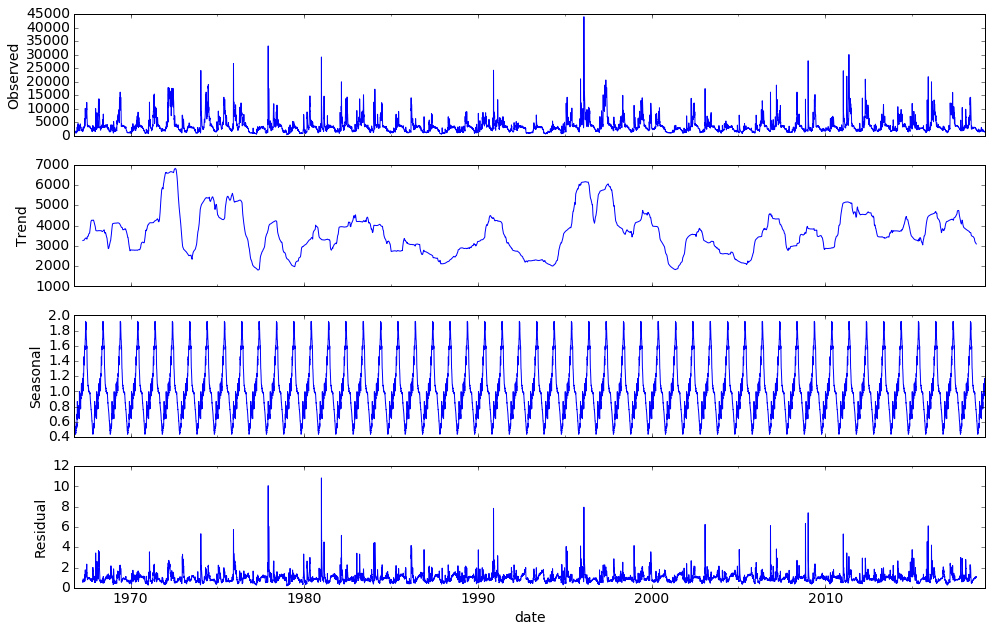

In [10]:
plt.style.use('classic')
%matplotlib inline
rcParams['figure.figsize'] = 14, 9
plt.rcParams.update({'font.size': 14})

decomposition = sm.tsa.seasonal_decompose(yakima_540, model='multiplicative', freq = 365)
decomposition.plot()
plt.show()

There seems a seasonal component which has a cycle on 12 months, which is expected in river discharge due to periodicity in precipitation. We can also see extreme valuates, such as a peak in between 1990 and 2000.

### Rolling Statistics

In [11]:
# Creat function to calculate and plot rolling statistics
def rolling_stats(data):
    plt.style.use('classic')
    %matplotlib inline
    rcParams['figure.figsize'] = 20, 9
    plt.rcParams.update({'font.size': 14})
    
    # Calculate rolling mean and standard deviation for a window of 12 months (365 days)
    rolmean = data.rolling(365).mean()
    rolstd = data.rolling(365).std()
    
    # Plot rolling statistics
    orig = plt.plot(data, color='blue',label='Original', linewidth=3.0)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=3.0)
    std = plt.plot(rolstd, color='green', label = 'Rolling Standard Deviation', linewidth=3.0)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

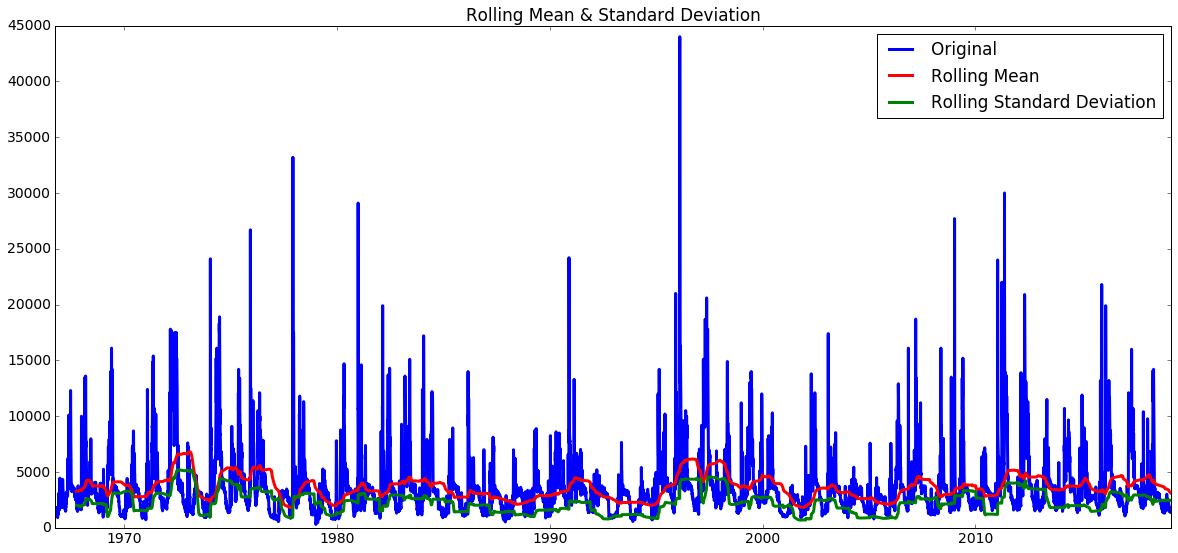

In [12]:
rolling_stats(yakima_540)

It turns out that the rolling mean and standard deviations vary slightly but there is no specific trend. This could mean the time series is likely stationery. This has to be further evaluated by a statistical test.

### Statistical Test

In [13]:
#Perform Dickey-Fuller test
def augmented_dickey_fuller(df):
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [14]:
print ('Results of Dickey-Fuller test for discharge station at Yakima' + '\n' + '-'*60)
augmented_dickey_fuller(yakima_540.mean_q_cfs)

Results of Dickey-Fuller test for discharge station at Yakima
------------------------------------------------------------


Test Statistic                -1.356947e+01
p-value                        2.229362e-25
#Lags Used                     1.800000e+01
Number of Observations Used    1.914200e+04
Critical Value (1%)           -3.430692e+00
Critical Value (5%)           -2.861691e+00
Critical Value (10%)          -2.566850e+00
dtype: float64

From the statistical test:
+ Test Statistic values are much less than the critical values 
+ The p-values are also smaller than the threshold values. 

These results indicate that the time series is stationary. ARIMA model can be implemented with no further data processing. However, slightly varying trends can be removed from the time series if the forecast models poorly fit.

### Select Optimum model parameters

The optimum parameters are estimated by diagnosing autocorrelation and partial autocorrelation as well as employing a grid search hyperparameter tuning method.  

#### Diagnosing Autocorreltaion and Partial Autocorrelation

Autocorrelation Function (ACF) is a measure of the correlation between the time series (ts) with a lagged version of itself.
Partial Autocorrelation Function (PACF) measures the correlation between the ts with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

Text(0.5, 0, 'Lag')

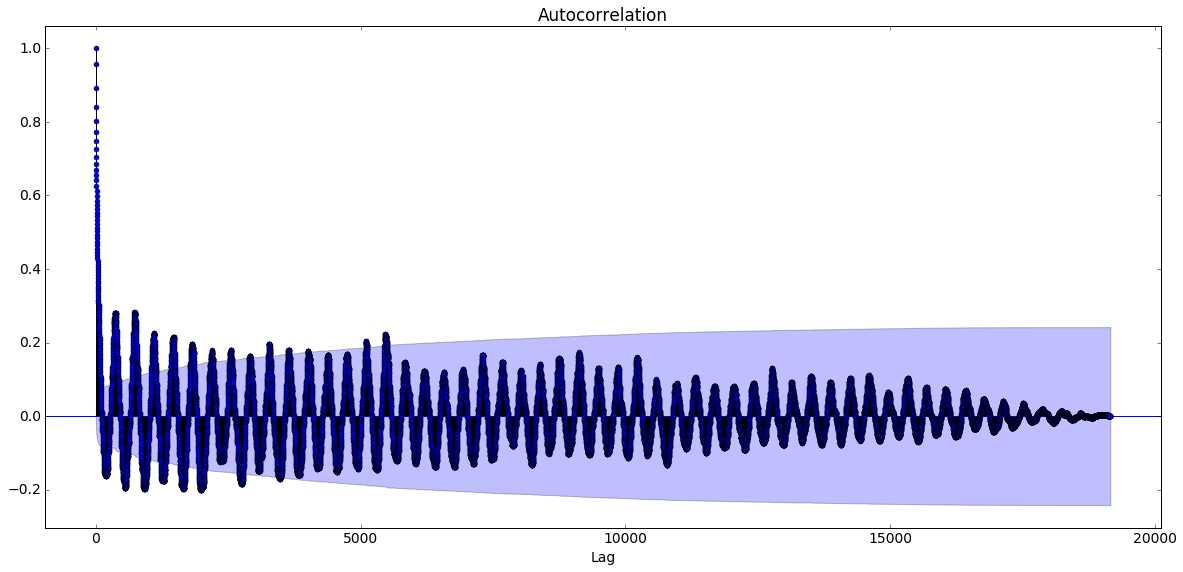

In [15]:
#ACF and PACF plots
plt.style.use('classic')
%matplotlib inline
rcParams['figure.figsize'] = 20, 9
plt.rcParams.update({'font.size': 14})

# Auto correlation for time series data
plot_acf(yakima_540, alpha = 0.06)
plt.xlabel('Lag')

The autocorrelation contains several lags that are above the significant line. 

In [16]:
def acf_pcf(df):
    plt.style.use('classic')
    %matplotlib inline
    plt.rcParams['figure.figsize'] = 20, 9
    plt.rcParams.update({'font.size': 14})

    lag_acf = acf(df, nlags=40)
    lag_pacf = pacf(df,nlags=50,method='ols')

    plt.subplot(121)
    plt.plot(lag_acf,marker='.', linewidth = 3.0)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray', linewidth = 3.0)
    plt.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray', linewidth = 3.0)
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.title('Autocorrelation function')

    plt.subplot(122)
    plt.plot(lag_pacf,marker='.', linewidth = 3.0)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray', linewidth = 3.0)
    plt.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray', linewidth = 3.0)
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.title('Partial Autocorrelation function')

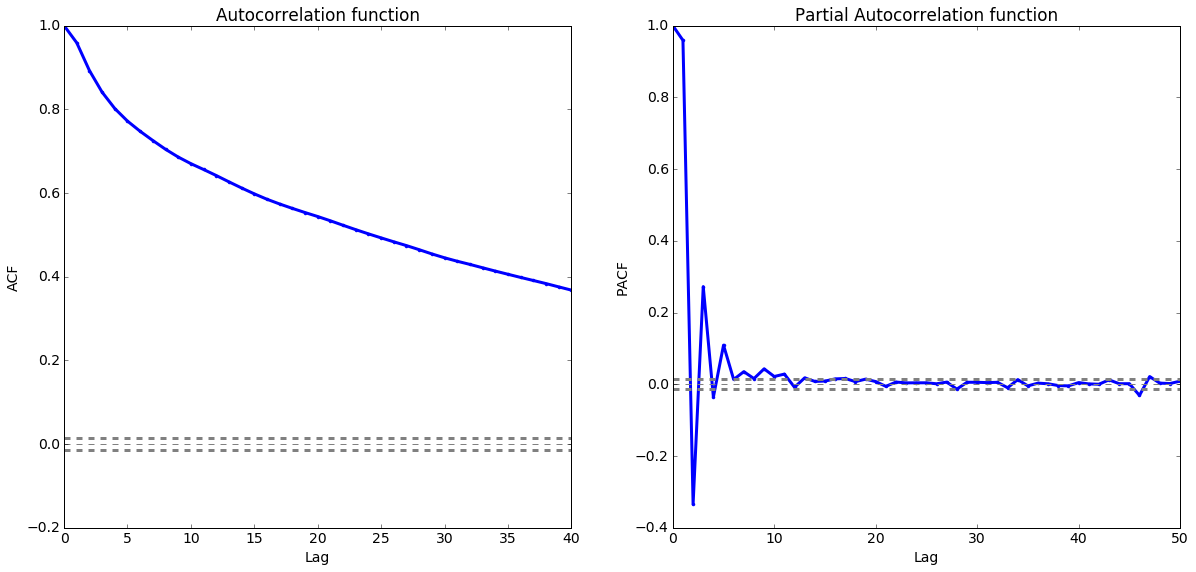

In [17]:
acf_pcf(yakima_540)

The ACF do not taper to zero and has no sinusoidal pattern (it is likely due to outliers), which indicates that the time series is non-stationary (contradicts with the previous tests). This suggest that differencing should be applied to improve the stationarity of time series.

#### Differencing to Eliminate Trend and Seasonality

Differencing is the most common method of dealing with both trend and seasonality. Differencing takes the difference of the original observation at a particular instant with that at the previous instant to improve stationarity. For this, first-order differencing is applied as follows.

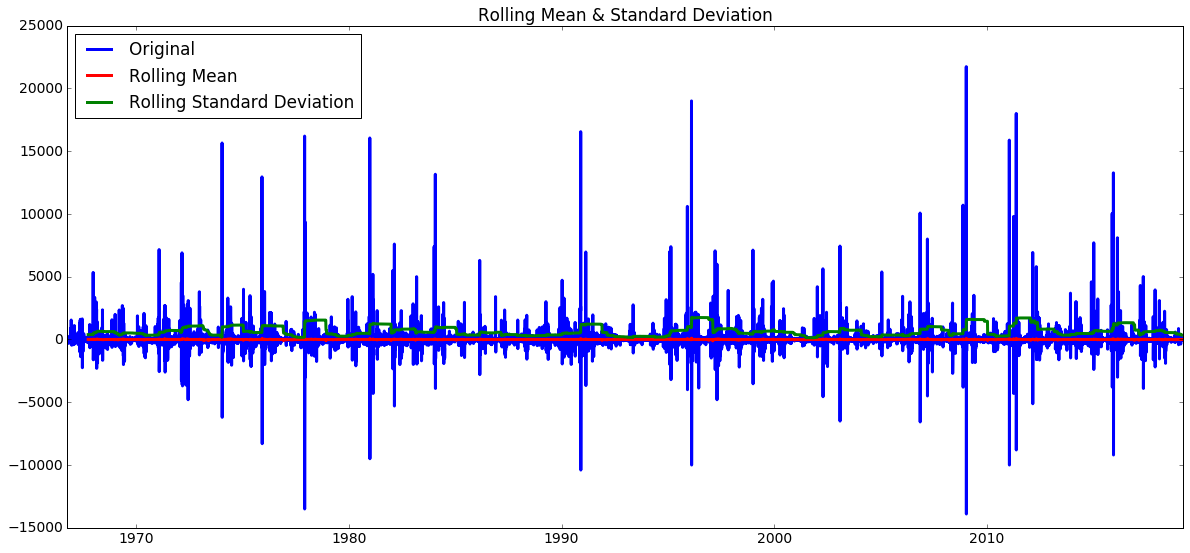

Test Statistic                   -25.941658
p-value                            0.000000
#Lags Used                        45.000000
Number of Observations Used    19114.000000
Critical Value (1%)               -3.430692
Critical Value (5%)               -2.861691
Critical Value (10%)              -2.566850
dtype: float64

In [18]:
first__order_difference = yakima_540 - yakima_540.shift(1)  
rolling_stats(first__order_difference)
augmented_dickey_fuller(first__order_difference['mean_q_cfs'].dropna(inplace=False))

The first difference improved the stationarity of the series. Next, the seasonal difference is implemented to remove the seasonality of the data and see how that impacts the stationarity of the data.

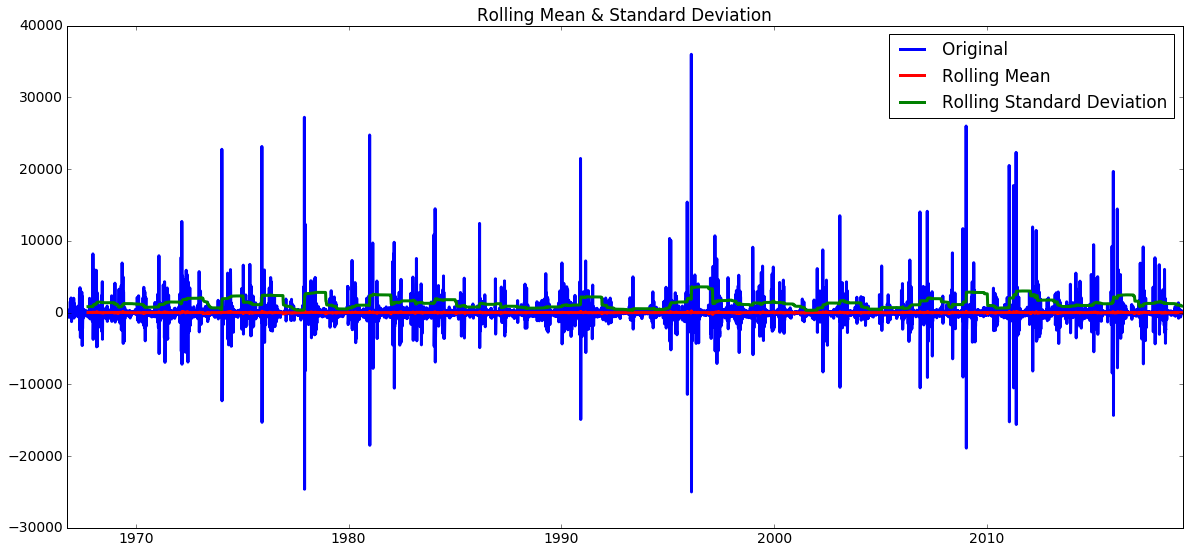

Test Statistic                   -25.045607
p-value                            0.000000
#Lags Used                        45.000000
Number of Observations Used    19112.000000
Critical Value (1%)               -3.430692
Critical Value (5%)               -2.861691
Critical Value (10%)              -2.566851
dtype: float64

In [19]:
seasonal_difference = yakima_540 - yakima_540.shift(3)  
rolling_stats(seasonal_difference)
augmented_dickey_fuller(seasonal_difference['mean_q_cfs'].dropna(inplace=False))

Compared to the original data the seasonal difference also improves the stationarity of the series. The next step is to take the first difference of the seasonal difference.

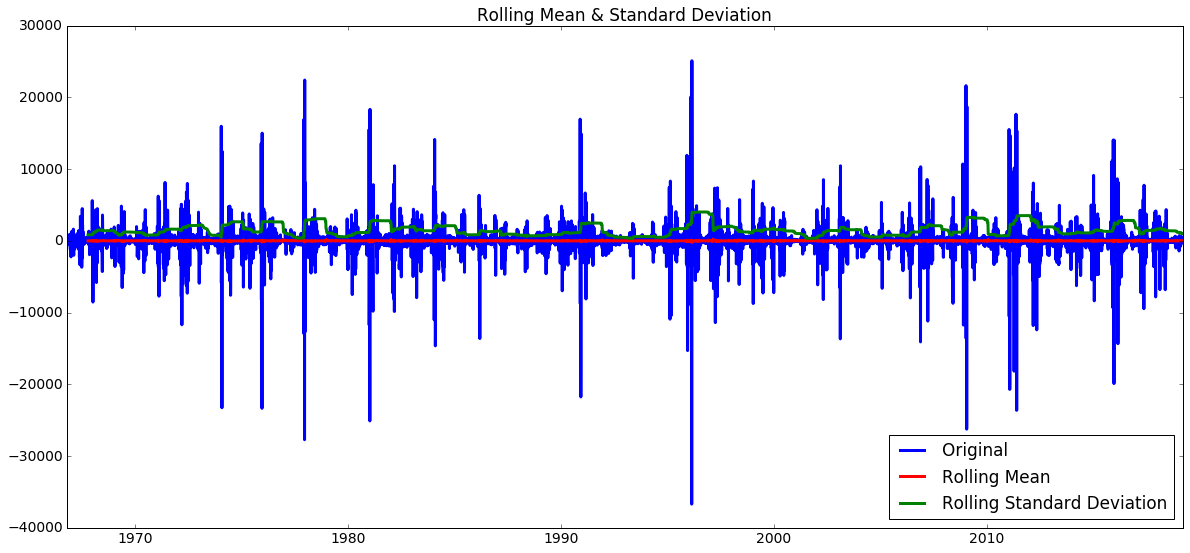

Test Statistic                   -29.358290
p-value                            0.000000
#Lags Used                        45.000000
Number of Observations Used    19100.000000
Critical Value (1%)               -3.430692
Critical Value (5%)               -2.861691
Critical Value (10%)              -2.566851
dtype: float64

In [20]:
seasonal_first_order_difference = first__order_difference - seasonal_difference.shift(12)  
rolling_stats(seasonal_first_order_difference)
augmented_dickey_fuller(seasonal_first_order_difference['mean_q_cfs'].dropna(inplace=False))

Looking at the test statistic and the p-value,  the seasonal first order difference has improved the time series dataset stationary.  

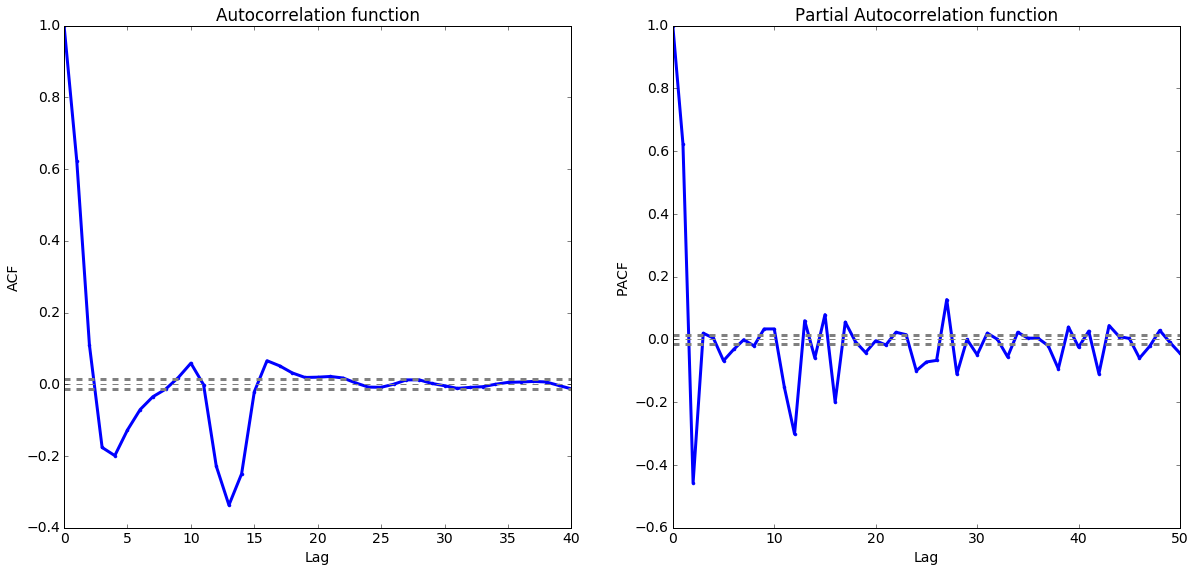

In [21]:
acf_pcf(seasonal_first_order_difference.dropna(inplace = False))

The ACF and PACF with differenced series have a sinusoidal pattern that converges to zero. From these plots, the first significant values at lag 2 for ACF and at lag 2 for the PACF suggest limiting p  and q values to 2. A big value at lag 12 in the ACF plot also suggests season parameter S = 12. Using this initial parameter values, a grid search is applied to obtain the optimum parameters.

#### Grid Search 
The optimal parameter values are systematically selected using the grid search (hyperparameter optimization) method.  The grid search iteratively explores different combinations of parameters. For each combination of parameters, a new seasonal ARIMA model is fit and ranked against one another based on how well it fits the data or its ability to accurately predict future data points. The AIC (Akaike Information Criterion) value criterion is used to rank each combination of parameters.

In [64]:
def param_gridsearch(limit):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, limit)

    # Generate all different combinations of p, d, and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal P, D and Q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    print('Examples of parameter combinations for Seasonal ARIMA' + '\n' + '-'*53)
    for i in range(5):
        print('SARIMAX: {} x {}'.format(pdq[i], seasonal_pdq[i]))
    return pdq, seasonal_pdq

In [65]:
# using 3 as a limit value for p, d, and q, determind from ACf and PCF plots
pdq, seasonal_pdq = param_gridsearch(2)

Examples of parameter combinations for Seasonal ARIMA
-----------------------------------------------------
SARIMAX: (0, 0, 0) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (1, 0, 0) x (1, 0, 0, 12)


We now have a set of triplets of parameters to train and evaluate ARIMA model. Next, the model will be fit and AIC (Akaike Information Criterion) value is used to compare the quality of models trained for each triplet of parameters.

The following function iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit 
the corresponding Seasonal ARIMA model 

In [24]:
# function to return combination of parameters with the minimum AIC value
def param_gridsearch(df, pdq, seasonal_pdq):
    warnings.filterwarnings("ignore")  #ignore warning messages
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try: 
                mod = sm.tsa.statespace.SARIMAX(df,
                                               order = param,
                                               seasonal_order = param_seasonal,
                                               enforce_stationarity = False,
                                               enforce_invertibility = False)
                results = mod.fit()
                # print combination of parameters with the minimum AIC value
                print('SARIMAX{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        
            except:
                continue
    return results

In [20]:
results = param_gridsearch(yakima_540, pdq, seasonal_pdq)

SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:30276.833364583435
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:29294.033046900844
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:27955.093986653832
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:27511.968438958796
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:27864.309376696816
SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:27685.43561860398
SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:27565.152433595336
SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:27488.809295025098
SARIMAX(0, 0, 1)x(0, 0, 0, 12) - AIC:29100.57234994485
SARIMAX(0, 0, 1)x(0, 0, 1, 12) - AIC:27158.797076693358
SARIMAX(0, 0, 1)x(0, 1, 0, 12) - AIC:26606.313044955416
SARIMAX(0, 0, 1)x(0, 1, 1, 12) - AIC:25833.13574817833
SARIMAX(0, 0, 1)x(1, 0, 0, 12) - AIC:26234.31568369103
SARIMAX(0, 0, 1)x(1, 0, 1, 12) - AIC:26022.713307359543
SARIMAX(0, 0, 1)x(1, 1, 0, 12) - AIC:25939.32516525257
SARIMAX(0, 0, 1)x(1, 1, 1, 12) - AIC:25811.766324253083
SARIMAX(0, 1, 0)x(0, 0, 0, 12) - AIC:24933.170873506384
SARIMAX(0, 1, 0)x(0, 0, 1, 12) - AIC:24636.2497572305

The seasonal ARIMA (1, 0, 1) x (1, 1, 1, 12) yields the lowest AIC value of 24227.34470465368. The corresponding set of parameters be an optimal option out of all combinations considered. In the next section. this particular model will be analyzed in more depth.

## Optimize Model

The set of best fitting model parameters SARIMA (0, 0, 1) x (2, 1, 1, 12) are used to fit the model and to perform an in-depth analysis. To determine whether the association between the response and each term in the model is statistically significant, we need to compare the p-value for the parameters to the significance level.

In [26]:
# Fit and display summary of model attribute
warnings.filterwarnings("ignore")
mod = sm.tsa.statespace.SARIMAX(yakima_540,
                                order=(1, 0, 1),
                                seasonal_order = (1, 1, 1, 12),
                                enforce_stationarity = False,
                                enforce_invertibility = False)

disrchage_model = mod.fit()

print(disrchage_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         mean_q_cfs   No. Observations:                19161
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood             -152502.997
Date:                            Thu, 25 Apr 2019   AIC                         305015.994
Time:                                    09:56:33   BIC                         305055.290
Sample:                                10-01-1966   HQIC                        305028.878
                                     - 03-17-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9212      0.001   1224.267      0.000       0.920       0.923
ma.L1          0.5061      0.001   

It turns out that the autoregressive (AR) and moving average(MA) have a p-value of 0, which indicate that each feature weight is statistically significant. Therefore, so it is reasonable to include the features in our model.

When fitting seasonal ARIMA models, it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. Next, the plot_diagnostics object is used to investigate for any unusual behavior. This is to ensure that the residuals of the model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

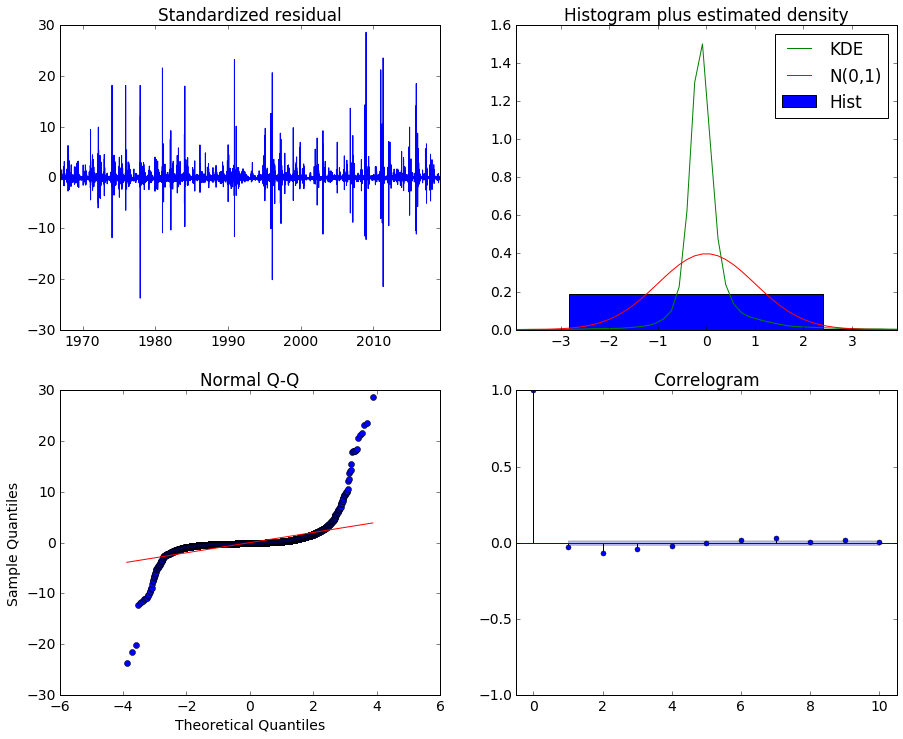

In [27]:
plt.style.use('classic')
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 12
plt.rcParams.update({'font.size': 14})

disrchage_model.plot_diagnostics()
plt.show()

Model diagnostics suggest that the model residuals suggesting that there is a room for improvement.
+ In the top left plot, the residual errors seem fine with near zero mean. However, the residual variance is not constant. 
+ In the top right plot (the histogram plus estimated density), we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 
+ The Normal Q-Q plot on the bottom left shows that the ordered distribution of residuals (blue dots) don't follows approximately the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are not normally distributed.
+ The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

### Validate Forecast
The accuracy of the forecast is validated with test data from 2017-01-01 to the end of the data. First, the dynamic is set to False argument to produce one-step ahead forecasts using the full history up to that point.

In [28]:
# Predict daily discharge using 2017 through 2019 as validating data
from datetime import datetime

pred = disrchage_model.get_prediction(start = '2017-01-01', dynamic = False)

# confidence intervals
pred_ci = pred.conf_int()

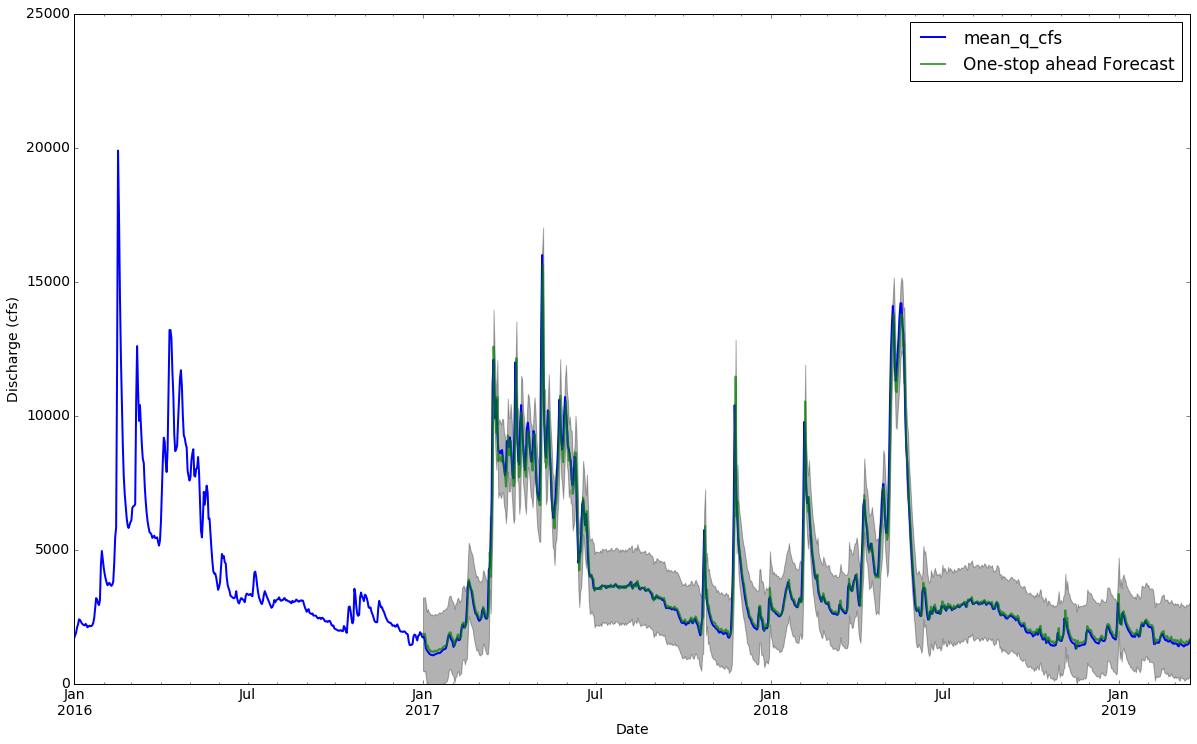

In [29]:
plt.rcParams.update({'font.size': 14})
ax = yakima_540['2016':].plot(label='observed', linewidth = 2)
pred.predicted_mean.plot(ax=ax,figsize=(20, 12),label='One-stop ahead Forecast', alpha=0.7, linewidth = 2)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:,0], 
                pred_ci.iloc[:,1], 
                color='k', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cfs)')

plt.ylim(0, 25000)
plt.legend()
plt.show()

Overall, forecasts results align with the observed values very well, showing an overall similar behavior. We need to calculate the accuracy of our forecasts RMSE, MAPE, and MASE to summarize the average error of our forecasts. 

In [30]:
rmse_12months = root_mean_squared_error(yakima_540['2017-01-01':], pred.predicted_mean)
mape_12months = mean_absolute_percentage_error (yakima_540['2017-01-01':], pred.predicted_mean)
mase_12months = mean_absolute_percentage_error(rmse_12months, naive_forcasted)

In [73]:
row = performance.shape[0]
performance.loc[row] = ['One-stop ahead forcast', '12 months', mase_12months, rmse_12months, mape_12months]

In [74]:
performance

,Model,Data Period,Mean Absolute Scaled Error (MASE),Root Mean squared Error (RMSE),Mean Absolue Percent Error (MAPE)
0,Naive Forcast,12 months,-,2067.0,21.0
1,One-stop ahead forcast,12 months,670,476.0,79.0


The one-step-ahead forecast outperforms naive prediction. The performance test needs to be also checked with the dynamic forecast. Dynamic forecast uses information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

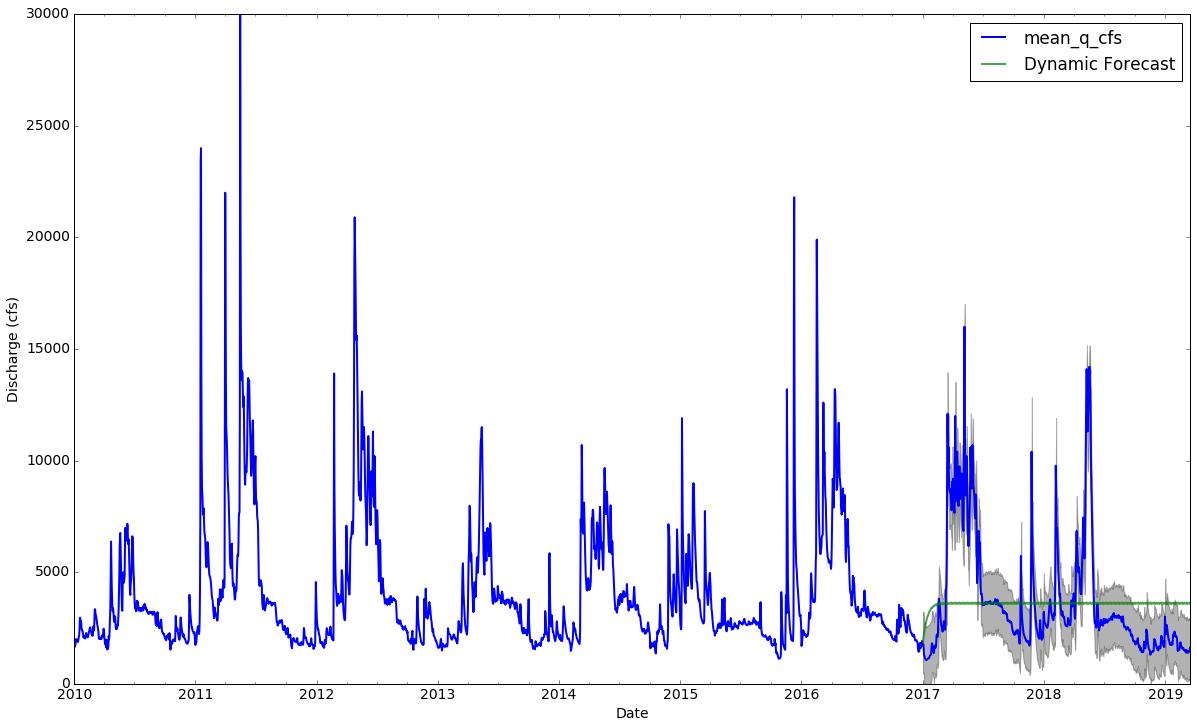

In [34]:
pred_dy = disrchage_model.get_prediction(start = '2017-01-01', dynamic=True, full_results=True)
pred_dy_ci = pred.conf_int()

plt.rcParams.update({'font.size': 14})

ax = yakima_540['2010':].plot(label='observed', linewidth = 2)
pred_dy.predicted_mean.plot(ax=ax,figsize=(20, 12),label='Dynamic Forecast', alpha=0.7, linewidth = 2)
ax.fill_between(pred_dy_ci.index, 
                pred_dy_ci.iloc[:,0], 
                pred_dy_ci.iloc[:,1], 
                color='k', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cfs)')

plt.ylim(0, 30000)
plt.legend()
plt.show()

In [35]:
rmse_12months_dy = root_mean_squared_error(yakima_540['2017-01-01':], pred_dy.predicted_mean)
mape_12months_dy = mean_absolute_percentage_error (yakima_540['2017-01-01':], pred_dy.predicted_mean)
mase_12months_dy = mean_absolute_percentage_error(rmse_12months_dy, naive_forcasted)

In [75]:
row = performance.shape[0]
performance.loc[row] = ['Dynamic forcast', '12 months', mase_12months_dy, rmse_12months_dy, mape_12months_dy]

In [76]:
performance

,Model,Data Period,Mean Absolute Scaled Error (MASE),Root Mean squared Error (RMSE),Mean Absolue Percent Error (MAPE)
0,Naive Forcast,12 months,-,2067.0,21.0
1,One-stop ahead forcast,12 months,670,476.0,79.0
2,Dynamic forcast,12 months,62,2669.0,58.0


Applying a linear statistical approach, SARIMA model, resulted  MAPE of 54% on dynamic forcast. This indicates that the linear modeling approach is not adptable to river flow fluctation. The seasonal abrupt changes in discharge flow are random and unpredictable are white noise to ARIMA model. To improve model performance, data seqgmention is applied.


# Time  Series Segmentation to Optimize Perfomance

On the dynamic forecast, the ARIMA model fits poorly where its performance did not improve the naive forecast. The dynamic forecast uses training data to fit and test data to evaluate performance, whereas one-step-ahead fit with all data and test data to evaluate performance. Therefore, performance on a dynamic forecast is a primary model evaluation criteria.

To improve model performance, data segmentation technique is applied. The goal of this project is to forecast the low flow period. We can use the month with lowest flow record to check if ARIMA performs better than the naive forecast. 

### Identify Lowest Discharge Month

The minimum daily discharge in each month is filtered for every year period.

In [38]:
# Minimum one day dicharge for each month
monthly_min_discharge = pd.crosstab(yakima_540.index.year, 
            yakima_540.index.strftime("%b"), 
            yakima_540.values, 
            aggfunc="min",
            rownames=["Year"],
            colnames=["Month"])
monthly_min_discharge.head()

Month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Year,,,,,,,,,,,,
1966,NaN,NaN,1610.0,NaN,NaN,NaN,NaN,NaN,NaN,920.0,1060.0,NaN
1967,1850.0,3200.0,1610.0,2520.0,1820.0,3240.0,5940.0,1480.0,2900.0,1820.0,1470.0,2480.0
1968,2010.0,2680.0,1150.0,2940.0,2350.0,3090.0,3010.0,2810.0,3080.0,1450.0,1340.0,2340.0
1969,5360.0,2890.0,1000.0,1470.0,950.0,3340.0,3360.0,1760.0,4770.0,1040.0,1050.0,2230.0
1970,1890.0,3180.0,1070.0,1470.0,800.0,3340.0,3050.0,1820.0,3100.0,870.0,920.0,2110.0


Rank of months based on average of the minimum daily discharge.

In [39]:
monthly_min_discharge.agg('min').sort_values()

Month
Jan     300.0
Dec     350.0
Feb     460.0
Nov     523.0
Mar     579.0
Apr     587.0
Oct     708.0
Sep     809.0
Aug    1860.0
May    1920.0
Jun    2200.0
Jul    2290.0
dtype: float64

The average daily discharge in each month is filtered for every year period.

In [40]:
# Aevrage monthly dicharge
monthly_mean_discharge = pd.crosstab(yakima_540.index.year, 
            yakima_540.index.strftime("%b"), 
            yakima_540.values, 
            aggfunc="mean",
            rownames=["Year"],
            colnames=["Month"]).dropna()
monthly_mean_discharge.head()

Month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Year,,,,,,,,,,,,
1967,2709.333333,3380.000000,3204.516129,3184.285714,2369.354839,3706.451613,8168.666667,1908.709677,5616.129032,2200.666667,1972.258065,2698.666667
1968,2897.333333,3460.322581,2444.838710,6176.206897,4247.096774,3455.483871,3951.333333,7030.645161,3718.709677,2394.666667,1641.935484,2686.000000
1969,6706.000000,3468.064516,1214.838710,1941.785714,2514.193548,3589.677419,7734.666667,3794.193548,10362.580645,1106.666667,1455.806452,2851.000000
1970,2887.333333,3397.741935,1366.774194,2391.428571,1327.419355,3607.419355,5402.333333,2665.806452,5174.193548,1185.333333,1566.129032,2721.333333
1971,6158.000000,3594.838710,1916.451613,4962.142857,3277.354839,4676.129032,8121.000000,2433.870968,9749.677419,1984.333333,1927.096774,2748.333333


Rank of months based on average of daily discharge.

In [41]:
monthly_mean_discharge.agg('min').sort_values()

Month
Jan     540.000000
Nov     710.133333
Mar     752.290323
Dec     881.741935
Feb     888.785714
Oct     895.516129
Sep    1411.266667
Apr    1607.833333
Aug    2350.645161
May    2475.483871
Jun    2480.000000
Jul    2650.000000
dtype: float64

This results indicates that January is the lowest river discharge period for Yakima river. The ARIMA model is implemented to forcast based on January records.

## Fit ARIMA with January Discharge Time Series

### Segement January Time Series

In [42]:
jan_q_cfs = yakima_540[yakima_540.index.month==1]
jan_q_cfs.index

DatetimeIndex(['1967-01-01', '1967-01-02', '1967-01-03', '1967-01-04',
               '1967-01-05', '1967-01-06', '1967-01-07', '1967-01-08',
               '1967-01-09', '1967-01-10',
               ...
               '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25',
               '2019-01-26', '2019-01-27', '2019-01-28', '2019-01-29',
               '2019-01-30', '2019-01-31'],
              dtype='datetime64[ns]', name='date', length=1643, freq=None)

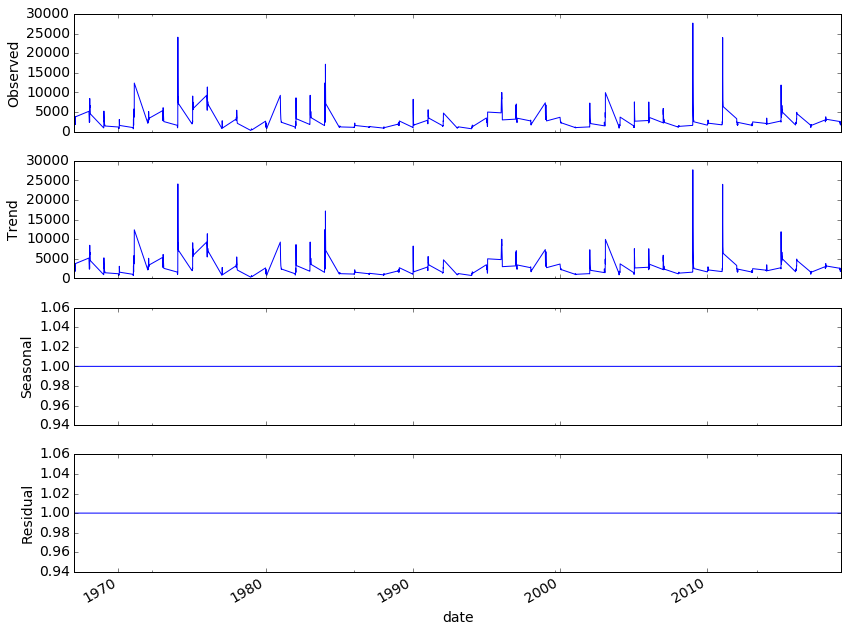

In [43]:
plt.style.use('classic')
%matplotlib inline
rcParams['figure.figsize'] = 12, 9
plt.rcParams.update({'font.size': 14})
decomposition = sm.tsa.seasonal_decompose(jan_q_cfs, model='multiplicative', freq = 1)
decomposition.plot()
plt.show()

The January time series show no outliers as shown in the residual plot. In this case, using ARIMA instead of seasonal ARIMA (SARIMA) is preferable.

### Grid Search for PDQ Parameters

In [66]:
pdq, seasonal_pdq = param_gridsearch(2)

Examples of parameter combinations for Seasonal ARIMA
-----------------------------------------------------
SARIMAX: (0, 0, 0) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (1, 0, 0) x (1, 0, 0, 12)


In [45]:
model_2 = param_gridsearch(jan_q_cfs, pdq, seasonal_pdq)

SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:31762.391373489198
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:31062.128497539783
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:30831.526292266946
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:29987.876662423383
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:30563.316022139734
SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:30246.46609907601
SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:30360.010226623133
SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:29960.628542987044
SARIMAX(0, 0, 1)x(0, 0, 0, 12) - AIC:30032.37070066461
SARIMAX(0, 0, 1)x(0, 0, 1, 12) - AIC:29411.711607054935
SARIMAX(0, 0, 1)x(0, 1, 0, 12) - AIC:29783.087127267874
SARIMAX(0, 0, 1)x(0, 1, 1, 12) - AIC:29288.804059780585
SARIMAX(0, 0, 1)x(1, 0, 0, 12) - AIC:29178.620675701946
SARIMAX(0, 0, 1)x(1, 0, 1, 12) - AIC:28810.49253082083
SARIMAX(0, 0, 1)x(1, 1, 0, 12) - AIC:29472.383686355588
SARIMAX(0, 0, 1)x(1, 1, 1, 12) - AIC:28523.160663410163
SARIMAX(0, 1, 0)x(0, 0, 0, 12) - AIC:28204.921855446788
SARIMAX(0, 1, 0)x(0, 0, 1, 12) - AIC:28012.68650352

Best SARIMAX(1, 0, 0) x (0, 1, 1, 12) - AIC:27761.662750559437

### Fit ARIMA

In [46]:
# Fit and display summary of model attribute
warnings.filterwarnings("ignore")
mod_1 = sm.tsa.statespace.SARIMAX(jan_q_cfs,
                                order=(1, 0, 0),
                                seasonal_order = (0, 1, 1, 12),
                                enforce_stationarity = False,
                                enforce_invertibility = False)

model_arima = mod_1.fit()

print(model_arima.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         mean_q_cfs   No. Observations:                 1643
Model:             SARIMAX(1, 0, 0)x(0, 1, 1, 12)   Log Likelihood              -13877.831
Date:                            Thu, 25 Apr 2019   AIC                          27761.663
Time:                                    10:06:37   BIC                          27777.830
Sample:                                         0   HQIC                         27767.663
                                           - 1643                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8633      0.004    196.087      0.000       0.855       0.872
ma.S.L12      -1.0195      0.010   

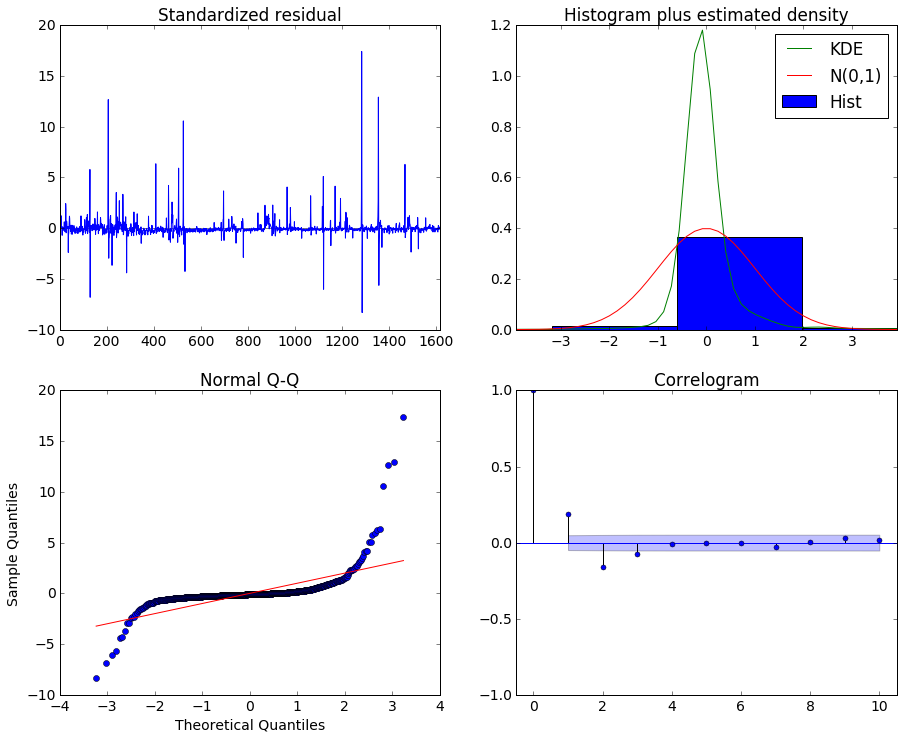

In [47]:
# diagonize model
plt.style.use('classic')
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 12
plt.rcParams.update({'font.size': 14})

model_arima.plot_diagnostics()
plt.show()

### Validate Forcast

#### Naive Forcast for January Time Series

In [48]:
naive_observed_jan, naive_forcasted_jan = naive_forcast(jan_q_cfs)
rmse_naive_jan = root_mean_squared_error(naive_observed_jan, naive_forcasted_jan)
mape_naive_jan = mean_absolute_percentage_error(naive_observed_jan, naive_forcasted_jan)

In [77]:
row = performance.shape[0]
performance.loc[row] = ['Naive Forcast', 'January', '-', rmse_naive_jan, mape_naive_jan]

In [78]:
performance

,Model,Data Period,Mean Absolute Scaled Error (MASE),Root Mean squared Error (RMSE),Mean Absolue Percent Error (MAPE)
0,Naive Forcast,12 months,-,2067.0,21.0
1,One-stop ahead forcast,12 months,670,476.0,79.0
2,Dynamic forcast,12 months,62,2669.0,58.0
3,Naive Forcast,January,-,2831.0,37.0


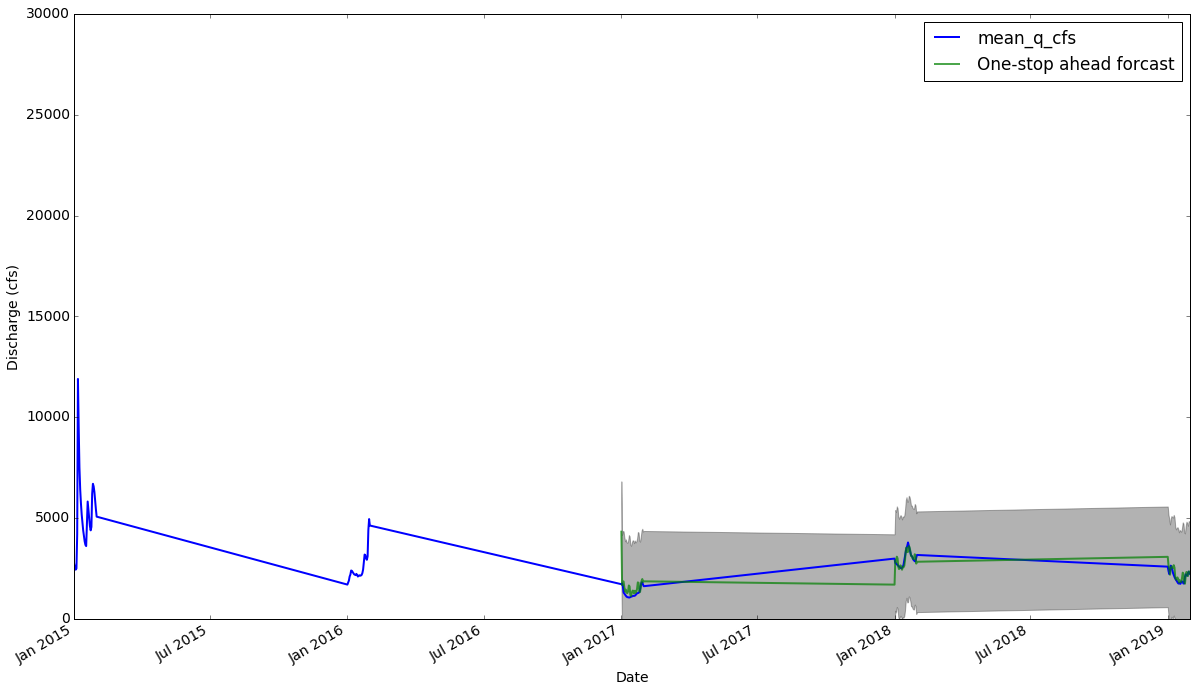

In [51]:
# One-stop ahead forcast
pred_1 = model_arima.get_prediction(start = 1550, dynamic = False)
pred_1_ci = pred_1.conf_int()

plt.rcParams.update({'font.size': 14})

ax = jan_q_cfs['2015-01-01':].plot(label='observed', linewidth = 2)
pred_1.predicted_mean.plot(ax=ax,figsize=(20, 12),label='One-stop ahead forcast', alpha=0.7, linewidth = 2)
ax.fill_between(pred_1_ci.index, 
                pred_1_ci.iloc[:,0], 
                pred_1_ci.iloc[:,1], 
                color='k', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cfs)')

plt.ylim(0, 30000)
plt.legend()
plt.show()

In [52]:
rmse_jan = root_mean_squared_error(jan_q_cfs['2017-01-01':], pred_1.predicted_mean)
mape_jan = mean_absolute_percentage_error (jan_q_cfs['2017-01-01':], pred_1.predicted_mean)
mase_jan = mean_absolute_percentage_error(rmse_naive_jan, naive_forcasted_jan)

In [79]:
row = performance.shape[0]
performance.loc[row] = ['One-stop ahead forcast', 'January', mase_jan, rmse_jan, mape_jan]

In [80]:
performance

,Model,Data Period,Mean Absolute Scaled Error (MASE),Root Mean squared Error (RMSE),Mean Absolue Percent Error (MAPE)
0,Naive Forcast,12 months,-,2067.0,21.0
1,One-stop ahead forcast,12 months,670,476.0,79.0
2,Dynamic forcast,12 months,62,2669.0,58.0
3,Naive Forcast,January,-,2831.0,37.0
4,One-stop ahead forcast,January,50,385.0,46.0


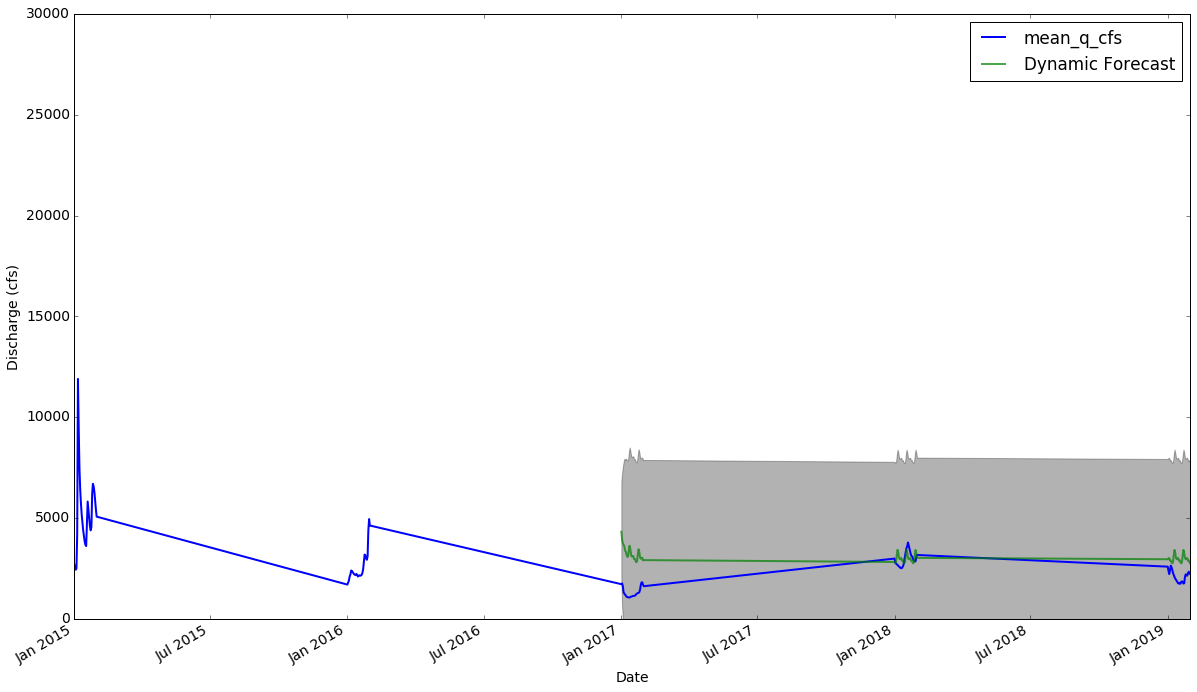

In [55]:
pred_dy1 = model_arima.get_prediction(start = 1550, dynamic = True, full_results = True)
pred_dy1_ci = pred_dy1.conf_int()

plt.rcParams.update({'font.size': 14})

ax = jan_q_cfs['2015':].plot(label='observed', linewidth = 2)
pred_dy1.predicted_mean.plot(ax=ax,figsize=(20, 12),label='Dynamic Forecast', alpha=0.7, linewidth = 2)
ax.fill_between(pred_dy1_ci.index, 
                pred_dy1_ci.iloc[:,0], 
                pred_dy1_ci.iloc[:,1], 
                color='k', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cfs)')

plt.ylim(0, 30000)
plt.legend()
plt.show()

In [56]:
rmse_jan_dy = root_mean_squared_error(jan_q_cfs['2017-01-01':], pred_dy1.predicted_mean)
mape_jan_dy = mean_absolute_percentage_error (jan_q_cfs['2017-01-01':], pred_dy1.predicted_mean)
mase_jan_dy = mean_absolute_percentage_error(rmse_jan_dy, naive_forcasted_jan)

In [81]:
row = performance.shape[0]
performance.loc[row] = ['Dynamic forcast', 'January', mase_jan_dy, rmse_jan_dy, mape_jan_dy]

In [82]:
#performance.drop([5], inplace=True)

In [83]:
performance

,Model,Data Period,Mean Absolute Scaled Error (MASE),Root Mean squared Error (RMSE),Mean Absolue Percent Error (MAPE)
0,Naive Forcast,12 months,-,2067.0,21.0
1,One-stop ahead forcast,12 months,670,476.0,79.0
2,Dynamic forcast,12 months,62,2669.0,58.0
3,Naive Forcast,January,-,2831.0,37.0
4,One-stop ahead forcast,January,50,385.0,46.0
5,Dynamic forcast,January,132,1281.0,67.0


In [85]:
performance.to_csv('Performance.csv', index=False)

Fitting ARIMA with January data improved the prediction accuracy, which outperforms the naive forecast on the root mean square error (RMSE). Since RMSE is the primary prediction criteria (because it indicates the actual error magnitude), ARIMA can be a useful method to forecast river discharge. In the next section (part III), LSTM network is trained and its performance is compared with ARIMA.